In [94]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from DTLearner import DTLearner
from BagLearner import BagLearner
from RTLearner import RTLearner

In [3]:
inf = open('Data/Istanbul.csv')
data = [list(s.strip().split(',')) for s in inf.readlines()[1:]]
data = np.array([list(map(float, vals[1:])) for vals in data])

In [4]:
# split up data
train_pct = 0.6
train_rows = int(train_pct*data.shape[0])
trials = 10

# take randomly for each trial
train_masks = np.array([np.full(data.shape[0], False) for _ in np.arange(trials)])
for mask in train_masks:
    mask[:train_rows] = True
    np.random.shuffle(mask)

train_data = np.array([data[mask] for mask in train_masks])
test_data = np.array([data[~mask] for mask in train_masks])

trainX = train_data[:, :, :-1]
trainY = train_data[:, :, -1]

testX = test_data[:, :, :-1]
testY = test_data[:, :, -1]

In [5]:
# collect RMSE across leaf sizes for DTLearner
leaf_rng = np.arange(1, trainX.shape[1] // 5)

rmses_train = np.zeros((trainX.shape[0], leaf_rng.shape[0]))
rmses_test = np.zeros((testX.shape[0], leaf_rng.shape[0]))

for trial_idx in np.arange(trials):
    for leaf_size, _ in enumerate(leaf_rng):
        dtl = DTLearner(leaf_size=leaf_size)
        dtl.addEvidence(trainX[trial_idx], trainY[trial_idx])
    
        train_predY = dtl.query(trainX[trial_idx])
        test_predY = dtl.query(testX[trial_idx])
    
        train_obs = trainY.shape[1]
        test_obs = testY.shape[1]
    
        rmses_train[trial_idx][leaf_size] = math.sqrt(((trainY[trial_idx] - train_predY)**2).sum()/train_obs)
        rmses_test[trial_idx][leaf_size] = math.sqrt(((testY[trial_idx] - test_predY)**2).sum()/test_obs)

C:\Users\cflei\Miniconda3\envs\ml4t\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\cflei\Miniconda3\envs\ml4t\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


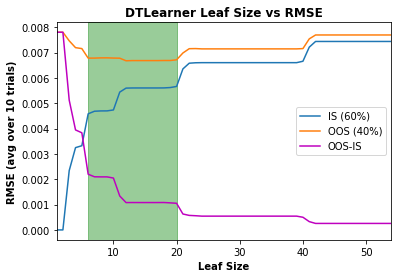

In [6]:
# plot RMSE vs leaf size for DTLearner
fig = plt.figure()
leaf_ax = fig.add_subplot(111)

leaf_ax.plot(leaf_rng, rmses_train.mean(axis=0), label=f'IS ({train_pct*100:0.0f}%)')
leaf_ax.plot(leaf_rng, rmses_test.mean(axis=0), label=f'OOS ({(1-train_pct)*100:0.0f}%)')
leaf_ax.plot(leaf_rng, rmses_test.mean(axis=0) - rmses_train.mean(axis=0), label=f'OOS-IS', c='m')
leaf_ax.axvspan(6, 20, color='g', alpha=0.4)

leaf_ax.set_xlim((1, leaf_rng[-10]))
leaf_ax.set_xlabel('Leaf Size', fontweight='bold')
leaf_ax.set_ylabel(f'RMSE (avg over {trials} trials)', fontweight='bold')
leaf_ax.set_title(f'DTLearner Generalization Error', fontweight='bold')
plt.legend()
plt.show()

In [7]:
# collect RMSE across leaf sizes for BagLearner
bag_rmses_train = np.zeros((trainX.shape[0], leaf_rng.shape[0]))
bag_rmses_test = np.zeros((testX.shape[0], leaf_rng.shape[0]))
bags = 25

for trial_idx in np.arange(trials):
    for leaf_size_idx, leaf_size in enumerate(leaf_rng):
        bgl = BagLearner(learner=DTLearner, bags=25, kwargs=dict(leaf_size=leaf_size))
        bgl.addEvidence(trainX[trial_idx], trainY[trial_idx])
    
        train_predY = bgl.query(trainX[trial_idx])
        test_predY = bgl.query(testX[trial_idx])
    
        train_obs = trainY.shape[1]
        test_obs = testY.shape[1]
    
        bag_rmses_train[trial_idx][leaf_size_idx] = math.sqrt(((trainY[trial_idx] - train_predY)**2).sum()/train_obs)
        bag_rmses_test[trial_idx][leaf_size_idx] = math.sqrt(((testY[trial_idx] - test_predY)**2).sum()/test_obs)

<Figure size 432x288 with 0 Axes>

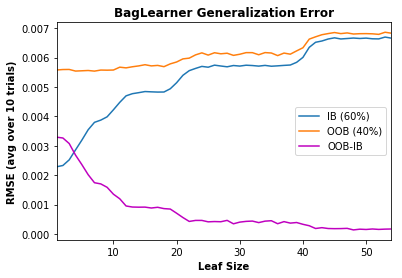

In [12]:
# plot RMSE vs leaf size for BagLearner
plt.clf()
fig = plt.figure()
bleaf_ax = fig.add_subplot(111)

bleaf_ax.plot(leaf_rng, bag_rmses_train.mean(axis=0), label=f'IB ({train_pct*100:0.0f}%)')
bleaf_ax.plot(leaf_rng, bag_rmses_test.mean(axis=0), label=f'OOB ({(1-train_pct)*100:0.0f}%)')
bleaf_ax.plot(leaf_rng, bag_rmses_test.mean(axis=0) - bag_rmses_train.mean(axis=0), label=f'OOB-IB', c='m')

bleaf_ax.set_xlim((1, leaf_rng[-10]))
bleaf_ax.set_xlabel('Leaf Size', fontweight='bold')
bleaf_ax.set_ylabel(f'RMSE (avg over {trials} trials)', fontweight='bold')
bleaf_ax.set_title(f'BagLearner Generalization Error', fontweight='bold')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

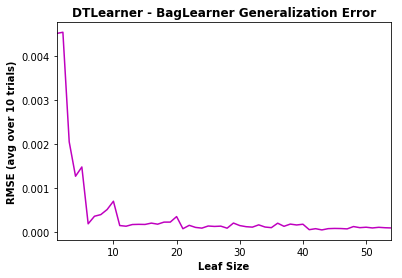

In [11]:
# plot RMSE vs leaf size for DTLearner - BagLearner
plt.clf()
fig = plt.figure()
dtbleaf_ax = fig.add_subplot(111)

dt_gen_err = rmses_test.mean(axis=0)-rmses_train.mean(axis=0)
bag_gen_err = bag_rmses_test.mean(axis=0)-bag_rmses_train.mean(axis=0)
dtbleaf_ax.plot(leaf_rng, dt_gen_err-bag_gen_err, c='m')

dtbleaf_ax.set_xlim((1, leaf_rng[-10]))
dtbleaf_ax.set_xlabel('Leaf Size', fontweight='bold')
dtbleaf_ax.set_ylabel(f'RMSE (avg over {trials} trials)', fontweight='bold')
dtbleaf_ax.set_title(f'DTLearner - BagLearner Generalization Error', fontweight='bold')
plt.show()

In [19]:
# collect predictions across tree count for BagLearner and DTLearner
bag_rng = np.arange(1, 10)
leaf_size = 6
bagdt_preds_train = np.zeros((trainX.shape[0], bag_rng.shape[0], trainX.shape[1]))
bagdt_preds_test = np.zeros((testX.shape[0], bag_rng.shape[0], testX.shape[1]))

for trial_idx in np.arange(trials):
    for bag_size_idx, bag_size in enumerate(bag_rng):
        bgl = BagLearner(learner=DTLearner, bags=bag_size, kwargs=dict(leaf_size=leaf_size))
        bgl.addEvidence(trainX[trial_idx], trainY[trial_idx])
    
        train_predY = bgl.query(trainX[trial_idx])
        test_predY = bgl.query(testX[trial_idx])
    
        bagdt_preds_train[trial_idx][bag_size_idx] = train_predY
        bagdt_preds_test[trial_idx][bag_size_idx] = test_predY

In [20]:
# collect predictions across tree count for BagLearner and RTLearner
bagrt_preds_train = np.zeros((trainX.shape[0], bag_rng.shape[0], trainX.shape[1]))
bagrt_preds_test = np.zeros((testX.shape[0], bag_rng.shape[0], testX.shape[1]))

for trial_idx in np.arange(trials):
    for bag_size_idx, bag_size in enumerate(bag_rng):
        bgl = BagLearner(learner=RTLearner, bags=bag_size, kwargs=dict(leaf_size=leaf_size))
        bgl.addEvidence(trainX[trial_idx], trainY[trial_idx])
    
        train_predY = bgl.query(trainX[trial_idx])
        test_predY = bgl.query(testX[trial_idx])

        bagrt_preds_train[trial_idx][bag_size_idx] = train_predY
        bagrt_preds_test[trial_idx][bag_size_idx] = test_predY

<Figure size 432x288 with 0 Axes>

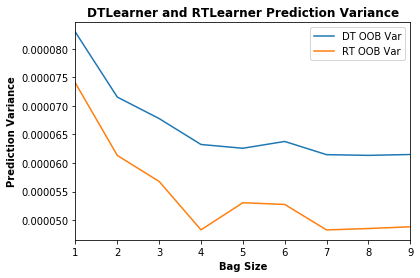

In [30]:
# plot mean variance of trial predictions across bag size for DTLearner and RTLearner
plt.clf()
fig = plt.figure()
dtrt_bag_ax = fig.add_subplot(111)

bagdt_mean_preds_variance = (bagdt_preds_test.std(axis=0)**2).mean(axis=1)
bagrt_mean_preds_variance = (bagrt_preds_test.std(axis=0)**2).mean(axis=1)

dtrt_bag_ax.plot(bag_rng, bagdt_mean_preds_variance, label=f'DT OOB Var')
dtrt_bag_ax.plot(bag_rng, bagrt_mean_preds_variance, label=f'RT OOB Var')

dtrt_bag_ax.set_xlim((1, bag_rng[-1]))
dtrt_bag_ax.set_xlabel('Bag Size', fontweight='bold')
dtrt_bag_ax.set_ylabel(f'Prediction Variance', fontweight='bold')
dtrt_bag_ax.set_title(f'DTLearner and RTLearner Prediction Variance', fontweight='bold')
plt.legend()
plt.show()

In [268]:
# DTLearner and RTLearner node count across trials
dt_node_counts = np.zeros((trials,), dtype=np.uint)
rt_node_counts = np.zeros((trials,), dtype=np.uint)

leaf_size = 6
for idx in np.arange(trials):
    dtl = DTLearner(leaf_size=leaf_size)
    dtl.addEvidence(trainX[idx], trainY[idx])
    dt_node_counts[idx] = dtl.tree[~np.isnan(dtl.tree[:, 2])].shape[0]
    
    rtl = RTLearner(leaf_size=leaf_size)
    rtl.addEvidence(trainX[idx], trainY[idx])
    rt_node_counts[idx] = rtl.tree[~np.isnan(rtl.tree[:, 2])].shape[0]

<Figure size 432x288 with 0 Axes>

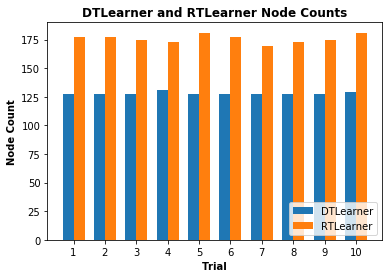

In [308]:
# plot DTLearner and RTLearner node counts across trials
plt.clf()
fig = plt.figure()
dtrt_node_ax = fig.add_subplot(111)

# dtrt_node_ax.plot(np.arange(1, trials+1), dt_node_counts, label=f'DTLearner')
# dtrt_node_ax.plot(np.arange(1, trials+1), rt_node_counts, label=f'RTLearner')
xlocs = np.arange(1, trials+1)
bar_w = 0.35

dtrt_node_ax.bar(xlocs - bar_w/2, dt_node_counts, bar_w, label=f'DTLearner')
dtrt_node_ax.bar(xlocs + bar_w/2, rt_node_counts, bar_w, label=f'RTLearner')

dtrt_node_ax.set_xlabel(f'Trial', fontweight='bold')
dtrt_node_ax.set_ylabel(f'Node Count', fontweight='bold')

dtrt_node_ax.set_xticklabels(np.arange(1, trials+1))
dtrt_node_ax.set_xticks(np.arange(1, trials+1))
dtrt_node_ax.set_title(f'DTLearner and RTLearner Node Counts', fontweight='bold')
plt.legend(loc=4)
plt.show()